In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy

In [2]:
# import functions from stomp_functions.py
import stomp_functions as stf

In [4]:
# import several real devices to test and compare
# For now only consider 5 qubit machines
from qiskit.providers.fake_provider import FakeAthens, FakeBelem, FakeEssex, FakeLondon 

In [5]:
# Define system parameters
N = 2
g = 1
J = 1

In [6]:
# Set up beta values and step size
beta = 0.6
num_steps = 100
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [7]:
# Construct tensored lists of pauli x and z for creating hamiltonian
z_ops, x_ops = stf.construct_op_lists(N)

In [8]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -J * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -J * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [9]:
# Create registers
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)

# Define initial wavefunction
#init_wf = [1 / np.sqrt(2**N) for i in range(2**N)]
init_wf = [0 for i in range(2 ** N)]
init_wf[0] = 1

In [10]:
# Define number of shots to use and backend for circuits
num_shots = 1*8192

In [12]:
# Perform hadamard estimation to get overlaps
he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, dt, init_wf)

# Get circuit depth before transpiling for later comparison
ideal_depths_re = [_.depth() for _ in he_circs_re]

In [14]:
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, dt, init_wf)

ideal_depths_im = [_.depth() for _ in he_circs_im]

In [15]:
# Perform Pauli decomposition on H
pauli_H = stf.pauli_string_decomp(H_qis, nq=N)

In [17]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_r_depths = {}
H_circs_i = {}
H_circs_i_depths = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 init_wf)
        H_circs_r_depths[key] = [_.depth() for _ in H_circs_r[key]]
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, init_wf)
        H_circs_i_depths[key] = [_.depth() for _ in H_circs_i[key]]

In [25]:
# Perform classical calculation for later comparisons
class_ovlp, class_H_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(), 
                                              H_qis.to_matrix(), num_steps, dt)

### Athens Machine

In [26]:
# Define backend
backend = FakeAthens()

In [27]:
# Get real value of expectations with no observable
ovlps_r_athens = stf.get_ovlps(he_circs_re, backend, num_shots)

In [28]:
# Now imaginary part
ovlps_i_athens = stf.get_ovlps(he_circs_im, backend, num_shots)

In [29]:
ovlps_athens = [ovlps_r_athens[i] + 1j * ovlps_i_athens[i] for i in range(len(ovlps_r_athens))]

In [30]:
# Get real part of H expectations
H_ovlps_re_athens = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re_athens += pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [31]:
# Get imag part of H expectations
H_ovlps_im_athens = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im_athens += 1j * pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [32]:
# Get total H expectation
total_H_ovlp_athens = H_ovlps_re_athens + H_ovlps_im_athens

Text(0.5, 1.0, 'Athens')

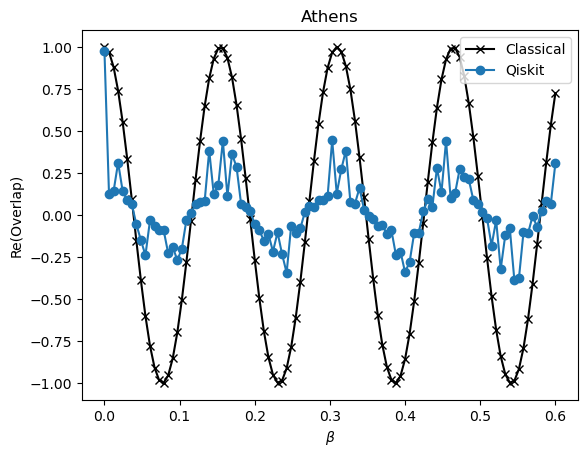

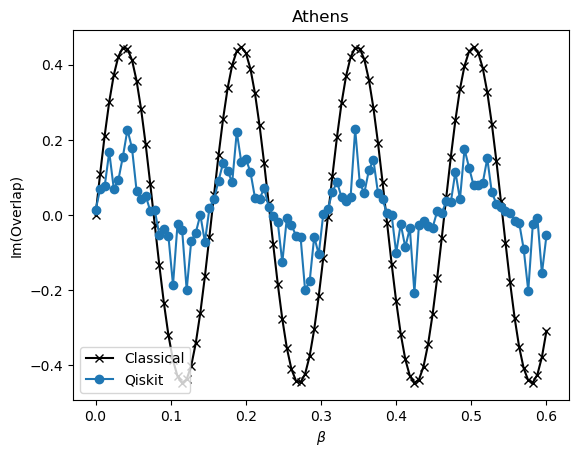

In [34]:
# Plot expectation value with no observable
plt.plot(betas, np.array(class_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_athens).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(Overlap)")
plt.legend(numpoints=1)
plt.title("Athens")

plt.figure(2)
plt.plot(betas, np.array(class_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_athens).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(Overlap)")
plt.legend(numpoints=1)
plt.title("Athens")

Text(0.5, 1.0, 'Athens')

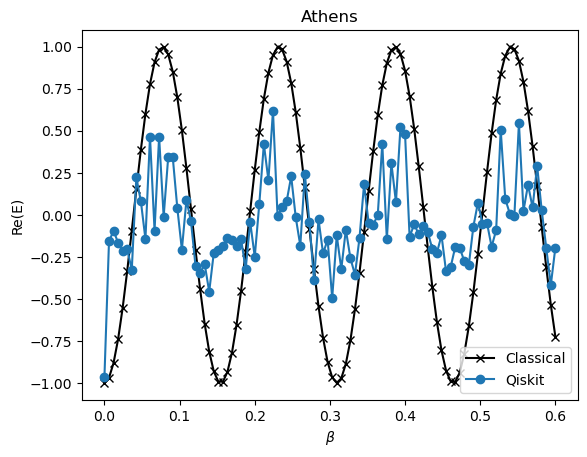

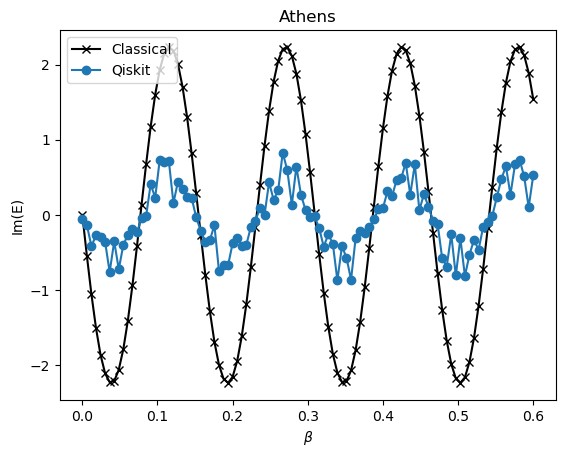

In [35]:
# Now the energy
plt.plot(betas, np.array(class_H_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_athens).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)
plt.title("Athens")

plt.figure(2)
plt.plot(betas, np.array(class_H_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_athens).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)
plt.title("Athens")

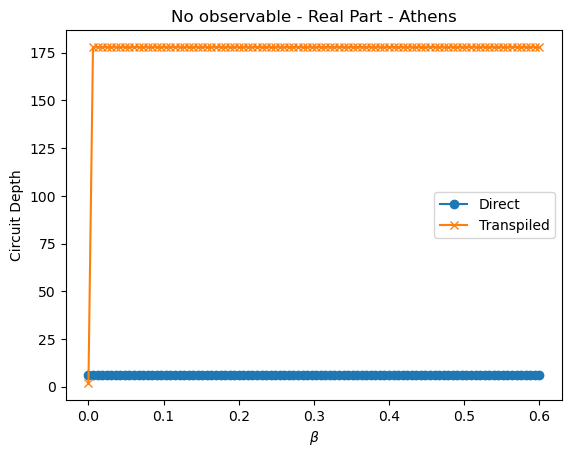

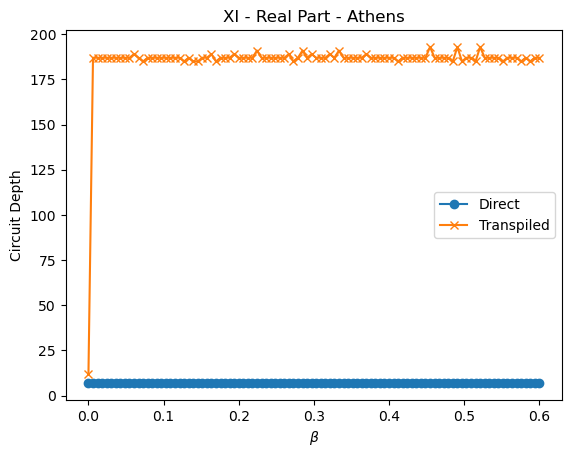

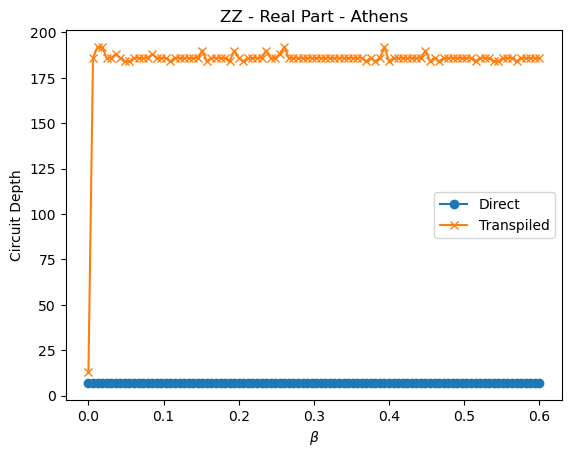

In [40]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_re_athens = transpile(he_circs_re, backend)
he_re_athens_depths = [_.depth() for _ in transpiled_he_re_athens]

plt.figure(1)
plt.plot(betas, ideal_depths_re, 'o-', label='Direct')
plt.plot(betas, he_re_athens_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Real Part - Athens")
plt.legend()

fignum = 2
H_re_athens_depths = {}
for key in H_circs_r:
    transpiled_H_re_athens = transpile(H_circs_r[key], backend)
    H_re_athens_depths[key] = [_.depth() for _ in transpiled_H_re_athens]
    plt.figure(fignum)
    plt.plot(betas, H_circs_r_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_re_athens_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Real Part - Athens")
    plt.legend()
    fignum += 1

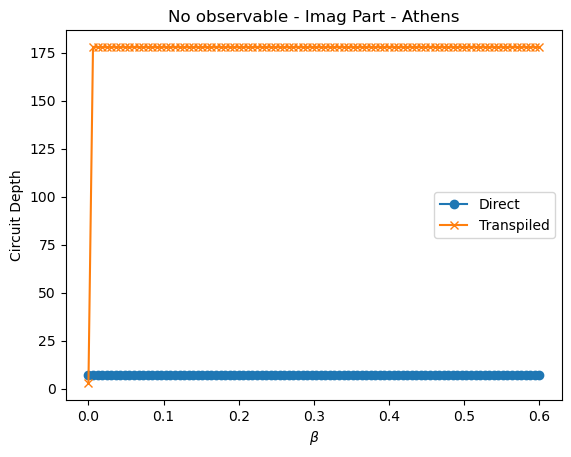

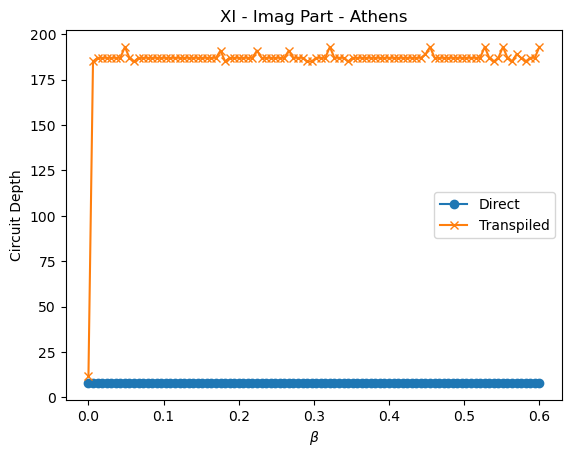

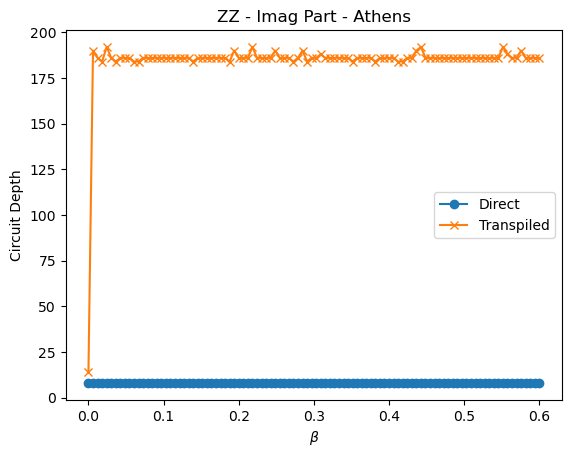

In [41]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_im_athens = transpile(he_circs_im, backend)
he_im_athens_depths = [_.depth() for _ in transpiled_he_im_athens]

plt.figure(1)
plt.plot(betas, ideal_depths_im, 'o-', label='Direct')
plt.plot(betas, he_im_athens_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Imag Part - Athens")
plt.legend()

fignum = 2
H_im_athens_depths = {}
for key in H_circs_r:
    transpiled_H_im_athens = transpile(H_circs_i[key], backend)
    H_im_athens_depths[key] = [_.depth() for _ in transpiled_H_im_athens]
    plt.figure(fignum)
    plt.plot(betas, H_circs_i_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_im_athens_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Imag Part - Athens")
    plt.legend()
    fignum += 1

### Belem Machine

In [42]:
# Define backend
backend = FakeBelem()

In [43]:
# Get real value of expectations with no observable
ovlps_r_belem = stf.get_ovlps(he_circs_re, backend, num_shots)

In [44]:
# Now imaginary part
ovlps_i_belem = stf.get_ovlps(he_circs_im, backend, num_shots)

In [45]:
ovlps_belem = [ovlps_r_belem[i] + 1j * ovlps_i_belem[i] for i in range(len(ovlps_r_belem))]

In [46]:
# Get real part of H expectations
H_ovlps_re_belem = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re_belem += pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [47]:
# Get imag part of H expectations
H_ovlps_im_belem = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im_belem += 1j * pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [48]:
# Get total H expectation
total_H_ovlp_belem = H_ovlps_re_belem + H_ovlps_im_belem

Text(0.5, 1.0, 'Belem')

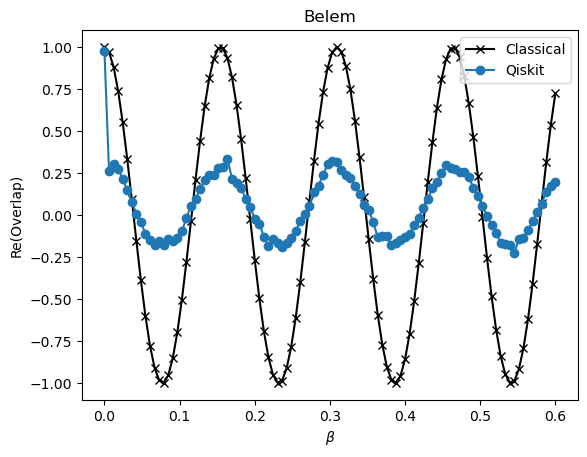

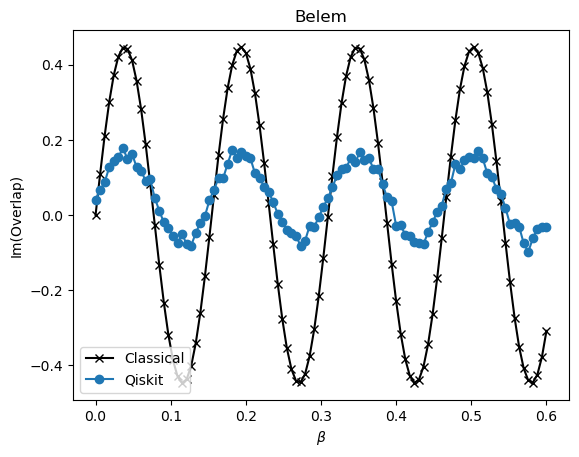

In [49]:
# Plot expectation value with no observable
plt.plot(betas, np.array(class_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_belem).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(Overlap)")
plt.legend(numpoints=1)
plt.title("Belem")

plt.figure(2)
plt.plot(betas, np.array(class_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_belem).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(Overlap)")
plt.legend(numpoints=1)
plt.title("Belem")

Text(0.5, 1.0, 'Belem')

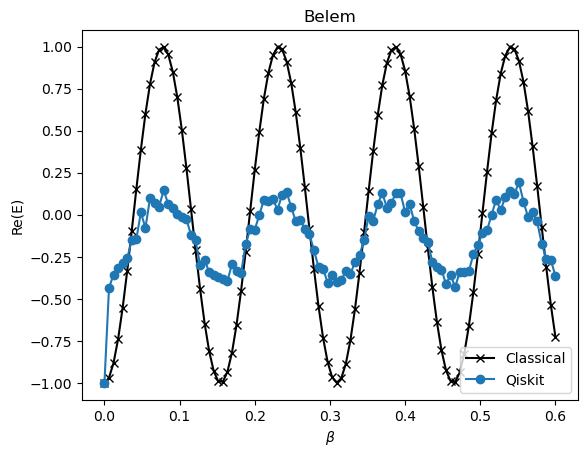

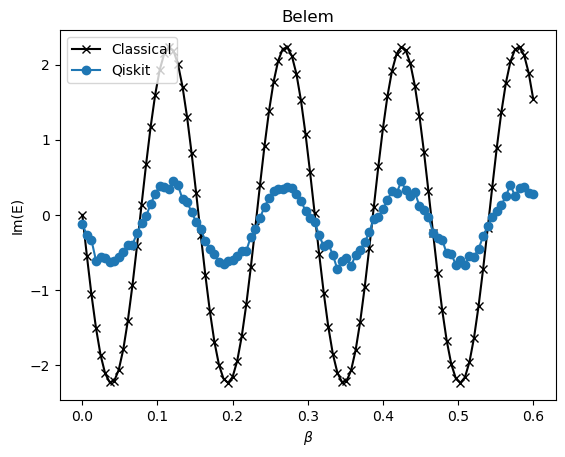

In [50]:
# Now the energy
plt.plot(betas, np.array(class_H_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_belem).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)
plt.title("Belem")

plt.figure(2)
plt.plot(betas, np.array(class_H_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_belem).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)
plt.title("Belem")

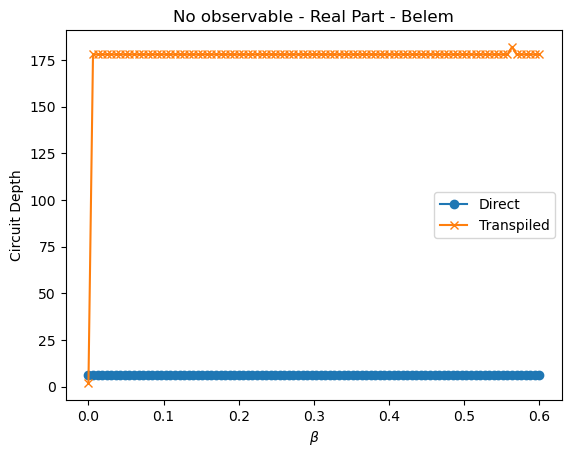

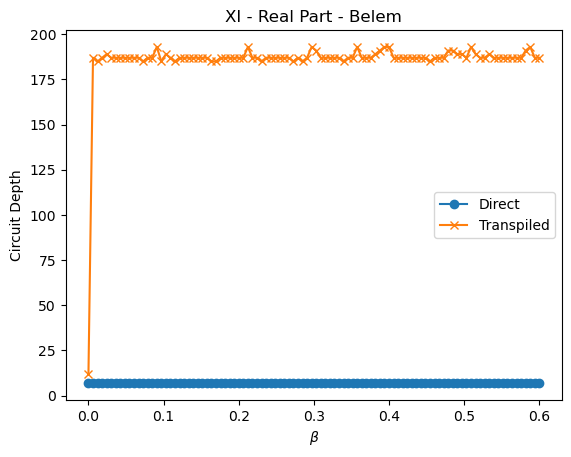

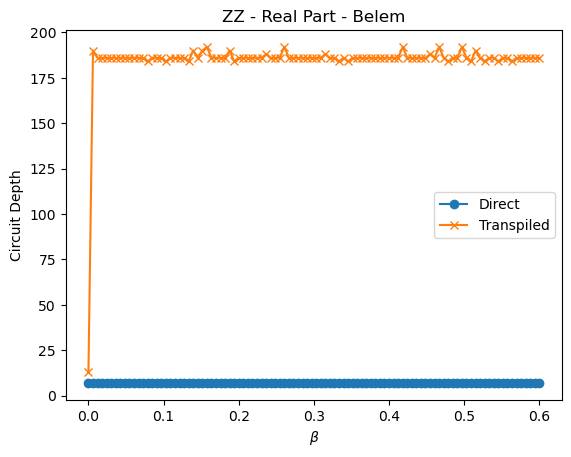

In [51]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_re_belem = transpile(he_circs_re, backend)
he_re_belem_depths = [_.depth() for _ in transpiled_he_re_belem]

plt.figure(1)
plt.plot(betas, ideal_depths_re, 'o-', label='Direct')
plt.plot(betas, he_re_belem_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Real Part - Belem")
plt.legend()

fignum = 2
H_re_belem_depths = {}
for key in H_circs_r:
    transpiled_H_re_belem = transpile(H_circs_r[key], backend)
    H_re_belem_depths[key] = [_.depth() for _ in transpiled_H_re_belem]
    plt.figure(fignum)
    plt.plot(betas, H_circs_r_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_re_belem_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Real Part - Belem")
    plt.legend()
    fignum += 1

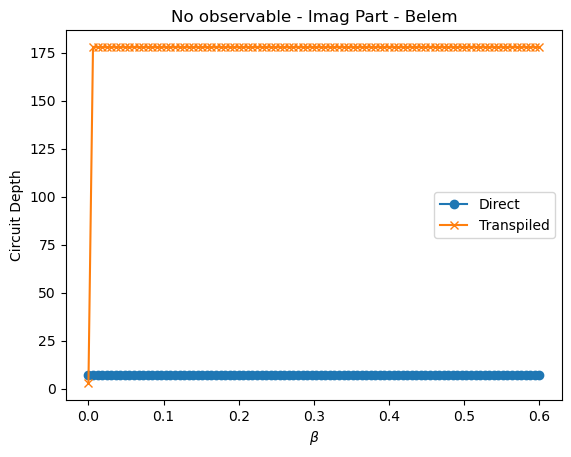

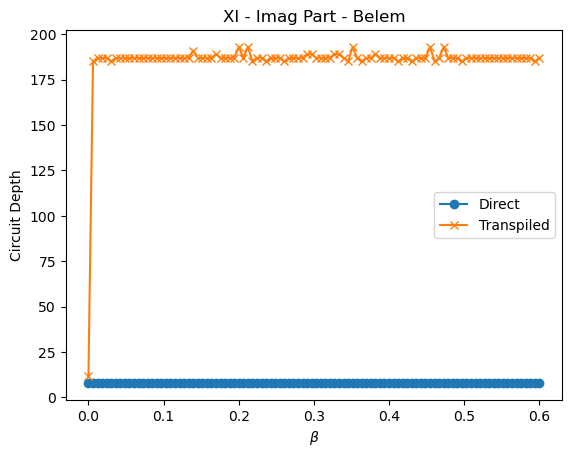

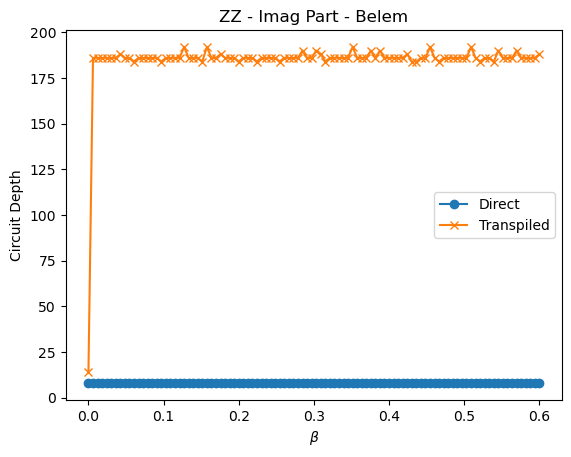

In [53]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_im_belem = transpile(he_circs_im, backend)
he_im_belem_depths = [_.depth() for _ in transpiled_he_im_belem]

plt.figure(1)
plt.plot(betas, ideal_depths_im, 'o-', label='Direct')
plt.plot(betas, he_im_belem_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Imag Part - Belem")
plt.legend()

fignum = 2
H_im_belem_depths = {}
for key in H_circs_r:
    transpiled_H_im_belem = transpile(H_circs_i[key], backend)
    H_im_belem_depths[key] = [_.depth() for _ in transpiled_H_im_belem]
    plt.figure(fignum)
    plt.plot(betas, H_circs_i_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_im_belem_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Imag Part - Belem")
    plt.legend()
    fignum += 1

### Essex Machine

In [54]:
# Define backend
backend = FakeEssex()

In [55]:
# Get real value of expectations with no observable
ovlps_r_essex = stf.get_ovlps(he_circs_re, backend, num_shots)

In [56]:
# Now imaginary part
ovlps_i_essex = stf.get_ovlps(he_circs_im, backend, num_shots)

In [57]:
ovlps_essex = [ovlps_r_essex[i] + 1j * ovlps_i_essex[i] for i in range(len(ovlps_r_essex))]

In [58]:
# Get real part of H expectations
H_ovlps_re_essex = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re_essex += pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [59]:
# Get imag part of H expectations
H_ovlps_im_essex = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im_essex += 1j * pauli_H[key] * np.array(temp) / np.sqrt(2 ** (2*N))

In [60]:
# Get total H expectation
total_H_ovlp_essex = H_ovlps_re_essex + H_ovlps_im_essex

Text(0.5, 1.0, 'Essex')

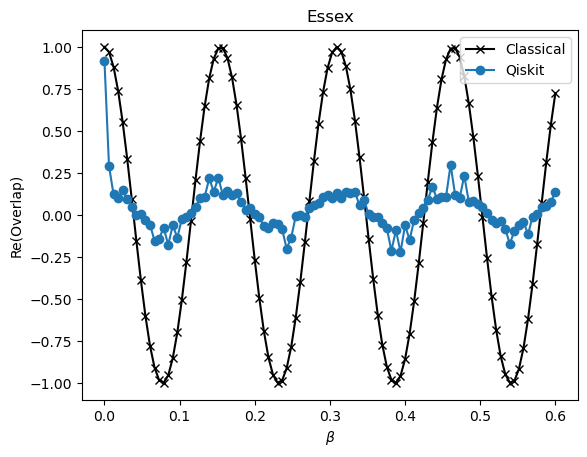

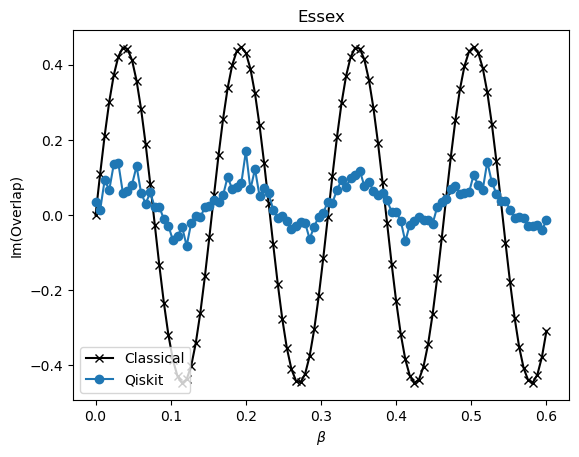

In [61]:
# Plot expectation value with no observable
plt.plot(betas, np.array(class_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_essex).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(Overlap)")
plt.legend(numpoints=1)
plt.title("Essex")

plt.figure(2)
plt.plot(betas, np.array(class_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(ovlps_essex).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(Overlap)")
plt.legend(numpoints=1)
plt.title("Essex")

Text(0.5, 1.0, 'Essex')

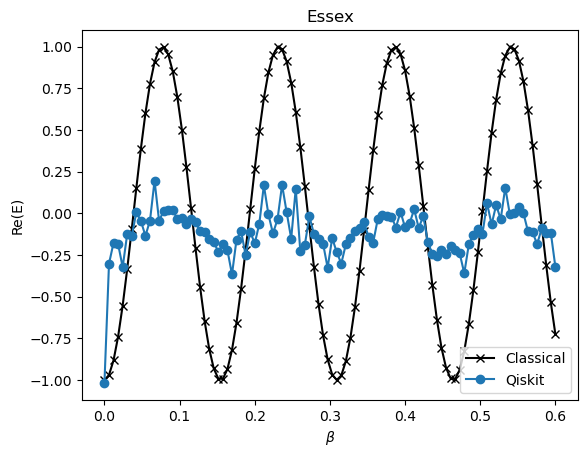

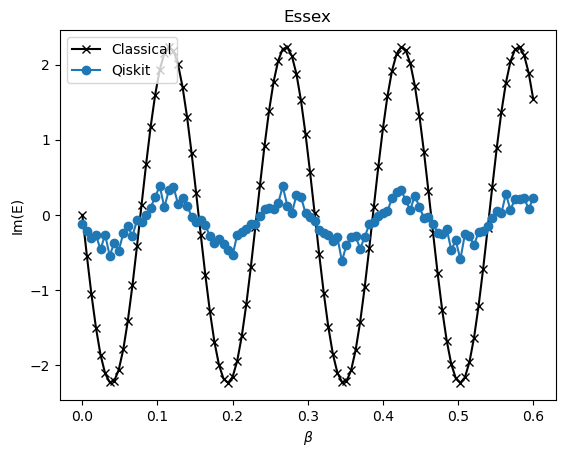

In [62]:
# Now the energy
plt.plot(betas, np.array(class_H_ovlp).real, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_essex).real, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)
plt.title("Essex")

plt.figure(2)
plt.plot(betas, np.array(class_H_ovlp).imag, 'kx-', label='Classical')
plt.plot(betas, np.array(total_H_ovlp_essex).imag, 'o-', label='Qiskit')
plt.xlabel("$\\beta$")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)
plt.title("Essex")

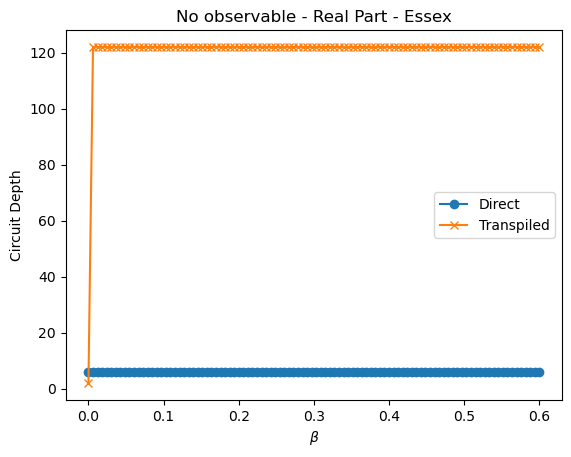

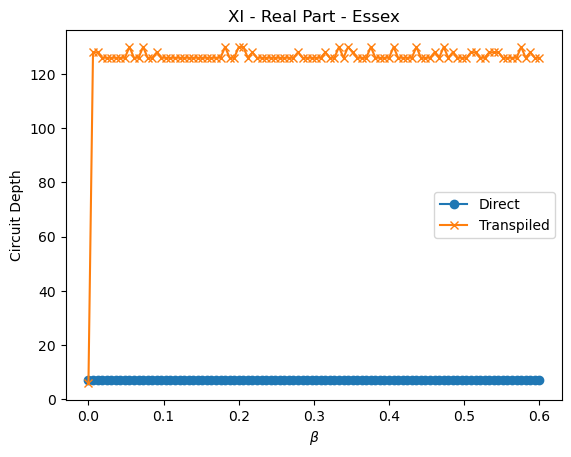

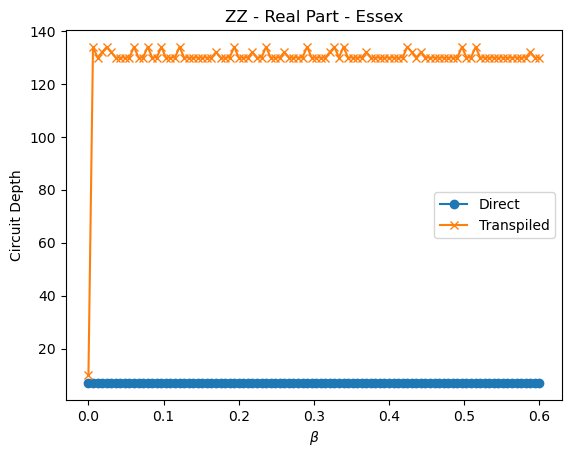

In [63]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_re_essex = transpile(he_circs_re, backend)
he_re_essex_depths = [_.depth() for _ in transpiled_he_re_essex]

plt.figure(1)
plt.plot(betas, ideal_depths_re, 'o-', label='Direct')
plt.plot(betas, he_re_essex_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Real Part - Essex")
plt.legend()

fignum = 2
H_re_essex_depths = {}
for key in H_circs_r:
    transpiled_H_re_essex = transpile(H_circs_r[key], backend)
    H_re_essex_depths[key] = [_.depth() for _ in transpiled_H_re_essex]
    plt.figure(fignum)
    plt.plot(betas, H_circs_r_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_re_essex_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Real Part - Essex")
    plt.legend()
    fignum += 1

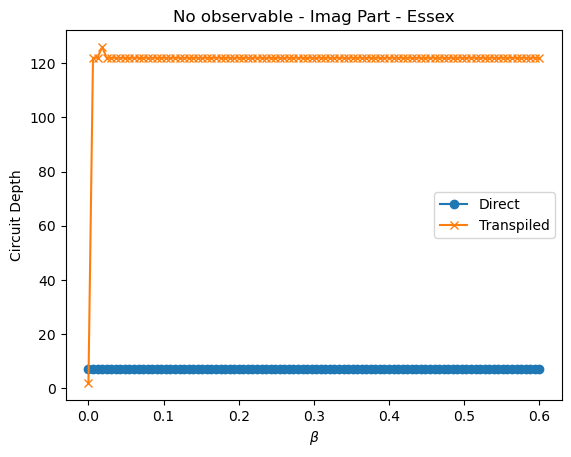

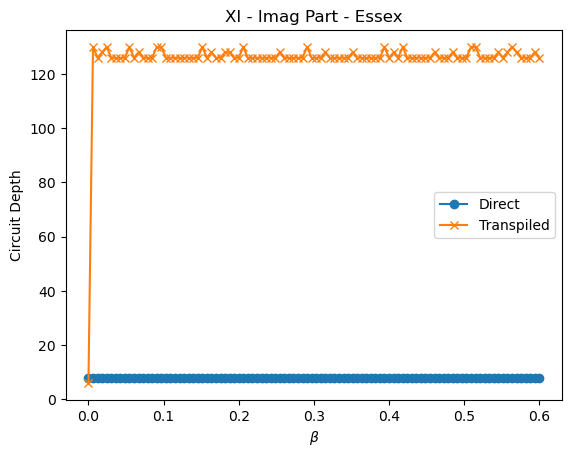

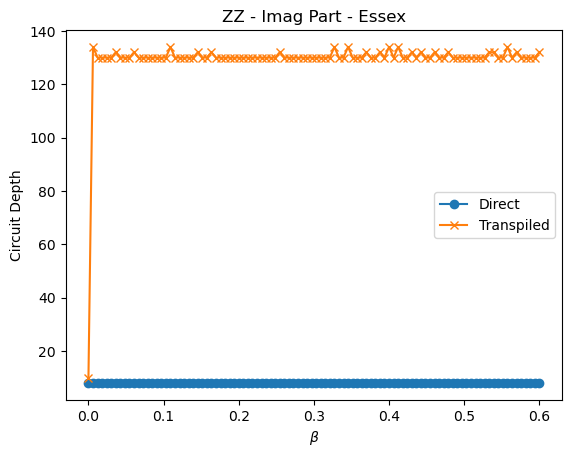

In [64]:
# Now transpile circuits to compare depths with ideal circuits
transpiled_he_im_essex = transpile(he_circs_im, backend)
he_im_essex_depths = [_.depth() for _ in transpiled_he_im_essex]

plt.figure(1)
plt.plot(betas, ideal_depths_im, 'o-', label='Direct')
plt.plot(betas, he_im_essex_depths, 'x-', label='Transpiled')
plt.xlabel("$\\beta$")
plt.ylabel("Circuit Depth")
plt.title("No observable - Imag Part - Essex")
plt.legend()

fignum = 2
H_im_essex_depths = {}
for key in H_circs_r:
    transpiled_H_im_essex = transpile(H_circs_i[key], backend)
    H_im_essex_depths[key] = [_.depth() for _ in transpiled_H_im_essex]
    plt.figure(fignum)
    plt.plot(betas, H_circs_i_depths[key], 'o-', label='Direct')
    plt.plot(betas, H_im_essex_depths[key], 'x-', label='Transpiled')
    plt.xlabel("$\\beta$")
    plt.ylabel("Circuit Depth")
    plt.title(key + " - Imag Part - Essex")
    plt.legend()
    fignum += 1